# WP7 - Exercise 1

---

### Support functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

def shear( sig_n, s1, s2 ) :
    """ 
    Creates a shear series for given values of principal stresses and sig_n
    """
    center = (s1 + s2)/2
    radius = (s1 - s2)/2
    dx = sig_n - center
    tau_sq = radius * radius - dx * dx
    tau_sq[ tau_sq < 0 ] = None
    return np.sqrt( tau_sq )

def mohr2d(s1, s3, ax, title="") :
    """ 
    Plot Mohr diagram 
    """
    # Setup data
    npts = 1000
 
    [s1,s3] = sorted([s1,s3], reverse=True)
    step = (s1-s3)/npts
    sig_n = np.sort( np.append( np.arange(s3,s1,step), [s1, s3]) )
    
    s13_tau = shear( sig_n, s1, s3 )

    # Do the plotting stuff
    ax.plot(sig_n, s13_tau, c='gray')

    ax.set_title(title, fontsize=20)
    ax.set_ylabel("Shear stress ($\\tau$)")
    ax.set_xlabel("Effective normal stress ($\sigma_n$)")

    return ax 


### Determine the best fitting parameters of a Coulomb criterion: $\sigma_1 = UCS + q \sigma_3$.

UCS=80.44 MPa q=4.5881


,S3_MPa,Pp_MPa,S1_MPa,Sig3_MPa,Sig1_MPa,I1_MPa,J2_MPa2,sqrt_J2_MPa
1,110,40.730779,409.023317,69.269221,368.292538,506.830979,29804.981366,172.641193
2,110,76.019958,342.219591,33.980042,266.199633,334.159717,17975.312781,134.072043
3,110,110.014132,189.773495,-0.014132,79.759362,79.731098,2121.270155,46.057249
4,70,-0.055399,399.750377,70.055399,399.805776,539.916574,36245.103735,190.381469
5,70,16.932524,339.904257,53.067476,322.971732,429.106683,24282.769258,155.829295
6,70,33.748003,288.242137,36.251997,254.494134,326.998129,15876.543480,126.002157
7,70,50.737176,226.162799,19.262824,175.425623,213.951271,8128.939967,90.160634
8,70,69.921900,140.320493,0.078100,70.398593,70.554794,1648.323920,40.599556
9,35,-0.145370,260.542030,35.145370,260.687400,330.978141,16956.402398,130.216752
10,35,7.266436,214.585236,27.733564,207.318800,262.785928,10750.285693,103.683584


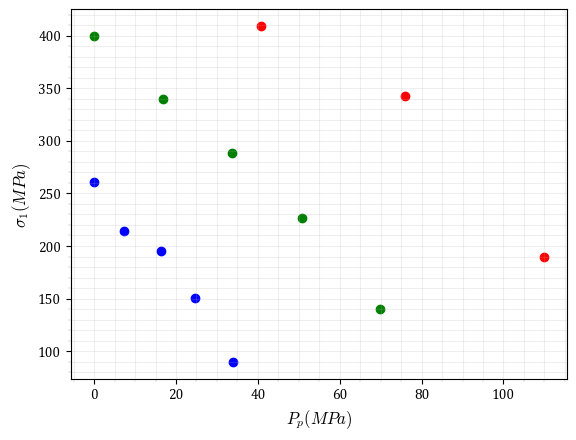

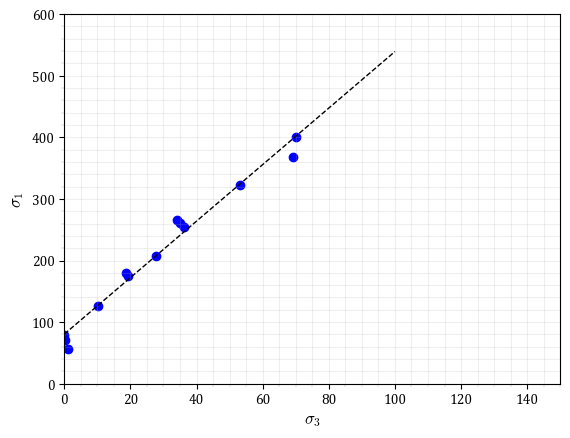

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("DarleyDaleDataset.xlsx")
df["Sig3_MPa"] = df.S3_MPa - df.Pp_MPa
df["Sig1_MPa"] = df.S1_MPa - df.Pp_MPa
# Filter values beyond the linearity
df = df[df.Sig3_MPa < 100]

df["I1_MPa"] = df.Sig1_MPa + 2*df.Sig3_MPa
s1=df.Sig1_MPa
s3=df.Sig3_MPa
df["J2_MPa2"] = 1/6*( 2 * (s1-s3)**2 )
df["sqrt_J2_MPa"] = np.sqrt(df.J2_MPa2)

fig, ax = plt.subplots()
for name, g in df.groupby('S3_MPa'):
    ax.scatter(g.Pp_MPa, g.S1_MPa)
ax.set_xlabel("$P_p (MPa)$")
ax.set_ylabel("$\sigma_1 (MPa)$")

from scipy.stats import linregress
Q, UCS, r_value, p_value, std_err = linregress( df.Sig3_MPa, df.Sig1_MPa )
Sig3_fit = np.linspace(0,100,10)
Sig1_fit = Sig3_fit * Q + UCS

fig, ax = plt.subplots()
ax.scatter(df.Sig3_MPa, df.Sig1_MPa)
ax.plot(Sig3_fit, Sig1_fit, ls='--', color='k')
ax.set_xlabel("$\sigma_3$")
ax.set_ylabel("$\sigma_1$")
ax.set_xlim(0,150)
ax.set_ylim(0,600)

print(f"UCS={UCS:.2f} MPa q={Q:.4f}")
df

### Determine the corresponding values of cohesive strength $S_0$ and friction angle $\varphi$ from point (1) and draw the shear failure line together with Mohr circles at failure. 

S0=18.78 MU=0.8376  PHI=39.95 deg


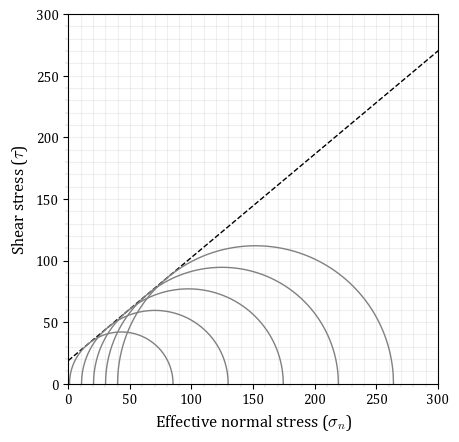

In [3]:
S0 = UCS / 2 / np.sqrt(Q)
MU = (Q-1) / 2 / np.sqrt(Q)

PHI = np.arctan(MU) 

print(f"S0={S0:.2f} MU={MU:.4f}  PHI={PHI*180/np.pi:.2f} deg")

sign=np.linspace(0,400,10)
tau = S0 + MU * sign

fig, ax = plt.subplots()
ax.plot(sign, tau, ls='--', color='k')
ax.set_xlim(0,300)
ax.set_ylim(0,300)

sig1_sig3 = Q
for sig3 in np.linspace(1,40,5) :
#    sig1 = sig1_sig3 * ( sig3 + S0 )
    sig1 = sig1_sig3 * ( sig3 + S0/MU ) - S0/MU
    mohr2d(sig1, sig3, ax)

ax.set_aspect('equal', 'box')

### Determine the corresponding fitting parameters for a Drucker-Prager criterion and plot experimental data in a $I_1$ v.s. $(J_2)^{1/2}$ space. 

Drucker-Prager:
   C3=20.35 C4=0.3174


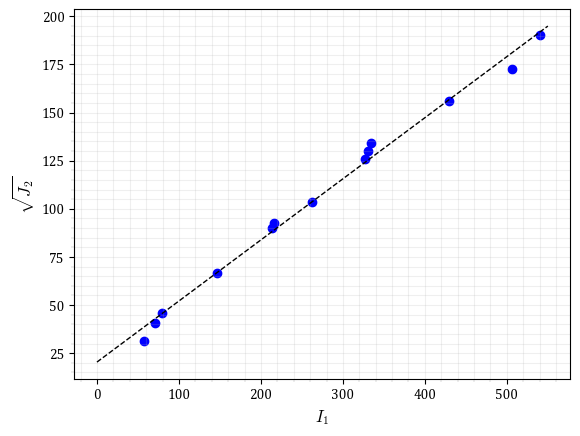

In [4]:
fig, ax = plt.subplots()
ax.scatter( df.I1_MPa, df.sqrt_J2_MPa )

from scipy.stats import linregress
C4, C3, r_value, p_value, std_err = linregress( df.I1_MPa, df.sqrt_J2_MPa  )
i1 = np.linspace(0,550,10)
sqrt_j2 = C3 + C4 * i1
ax.plot( i1, sqrt_j2, c='k', ls='--' )

ax.set_xlabel("$I_1$")
ax.set_ylabel("$\sqrt{J_2}$")

print("Drucker-Prager:")
print(f"   C3={C3:.2f} C4={C4:.4f}")


### Compute the corresponding tensile strength assuming a reasonable ratio of unconfined compression strength to tensile strength (browse Jaeger’s book). 
----

As of Section 4.5 and 4.6 of Jaeger's book, we can understand that a reasonable ration for $C_0/T_0 = [ \sqrt{\mu^2+1} + \mu ]^2$, or a reference value $C_0/T_0=15$. 

In [5]:
c0_t0 = ( np.sqrt( MU**2 + 1 ) + MU ) ** 2

C0 = UCS
T0 = C0 / c0_t0

print(f"\nC_0/T_0 = {c0_t0:.2f}")
print(f"UCS = {UCS:.2f}   T_0 = {T0:.2f} MPa")

# Using the ratio from a table in the book
c0_t0 = 15
C0 = UCS
T0 = C0 / c0_t0

print(f"\n\nC_0/T_0 = {c0_t0:.2f}")
print(f"UCS = {UCS:.2f}   T_0 = {T0:.2f} MPa")


C_0/T_0 = 4.59
UCS = 80.44   T_0 = 17.53 MPa


C_0/T_0 = 15.00
UCS = 80.44   T_0 = 5.36 MPa


# WP7 - Exercise 2

---

For this assignment you have to be able to calculate principal stresses on the wall of a wellbore at an arbitrary deviation and azimuth (See Chapter 6 of my notes “Wellbore stability” (https://dnicolasespinoza.github.io/) and Zoback's book Ch. 8).

Develop a script to compute and illustrate graphically (lower hemisphere projection):

1. The likelihood of tensile fractures considering wellbore mud pressure is equal to pore pressure in the formation $P_W = P_p$ and a simple tensile strength criterion (independent of intermediate and maximum principal stresses), i.e., required $T_s$.
1. The likelihood of breakouts considering wellbore mud pressure is equal to pore pressure in the formation $P_W = P_p$ and a simple unconfined compression strength criterion, i.e., required $UCS$.
1. The wellbore breakout angle $w_{BO}$ considering a Mohr-Coulomb shear failure criterion and the properties of the Darley Dale Sandstone from Exercise 1.
1. The wellbore breakout angle $w_{BO}$ considering a linear $I_1$ v.s. $(J_2)^{1/2}$ shear failure criterion and the properties of the Darley Dale Sandstone from Exercise 1.
1. The wellbore breakout angle $w_{BO}$ considering a Modified Lade shear failure criterion (Zoback's book, p. 100) and the properties of the Darley Dale Sandstone from point 1.

Limit your wellbore breakout angle plots to $0^{\circ} < w_{BO} < 60^{\circ}$ because predictions with linear elasticity over $w_{BO} > 60^{\circ}$ are likely highly inaccurate. Test your script with the three examples given in Zobacks's book in Figures 8.2 and 10.4 (normal faulting, strike-slip faulting, and reverse faulting). When computing breakouts assume $P_W$ = 32 MPa (NF), $P_W$ = 40 MPa (SSF), and $P_W$ = 52 MPa (RF). Use a Poisson ratio of 0.25 for stress calculations. 

In [1]:
#
#
#
def Sp_to_Sg(Sp, alpha, beta, gamma) :
  # ROTATION MATRIX
  CA, SA = np.cos(alpha), np.sin(alpha)
  CB, SB = np.cos(beta),  np.sin(beta)
  CG, SG = np.cos(gamma), np.sin(gamma)
  RPG = np.array(
        [ [ CA*CB,                SA*CB            ,   -SB  ],
          [ CA*SB*SG - SA*CG,     SA*SB*SG + CA*CG , CB*SG  ],
          [ CA*SB*CG + SA*SG,     SA*SB*CG - CA*SG , CB*CG  ]]
  )

  # MATRIX MULTIPLICATION - STRESS IN GEOGRAPHIC COORDINATES
  Sg = RPG.T @ Sp @ RPG
  return Sg

#
#
#
def Sg_to_Sw(Sg, delta, phi) :
  # ROTATION MATRIX
  CD = np.cos(delta)
  SD = np.sin(delta)
  CP = np.cos(phi)
  SP = np.sin(phi)
  
  Rb = np.array(
        [ [ -CD*CP,   -SD*CP ,  SP  ],
          [ SD,       -CD    ,   0  ],
          [ CD*SP,     SD*SP ,  CP  ]]
  )

  Sw = Rb @ Sg @ Rb.T
  return Sw

def range_levels(min, max, n_steps) :
    n_dec = 0
    _n = n_steps
    while ( True ) :
        step = ( max - min ) / n_steps
        step = round( step, n_dec )
        if ( not step ) :
            n_dec += 1
            continue
        _n = ( max - min ) / step
        levels = np.arange(np.floor(min*10**n_dec)/10**n_dec, max+step, step)

        if ( np.abs( _n - n_steps ) < n_steps*.5 ) : break   # Accept 20% deviation
        n_dec += 1
    return levels

In [4]:
import numpy as np
import pandas as pd
from numpy import sin, cos, pi
from numpy.linalg import eigvals
import matplotlib.pyplot as plt

def build_polar_plots() :

    global NU
    global S1, S2, S3, AZIMUTH, REGIME
    global PW, PP
    
    # Mohr coulomb failure criteria: Sig1 = UCS + Q * Sig3
    global MC_UCS, MC_Q
    # I1 x J2 Drucker Parger failure criteria: SQRT_J2 = C3 + V4 * I1
    global DP_C3, DP_C4, DP_I1, DP_SJ2

    DP_I1 = []
    DP_SJ2 = []
    
    MC_S0 = MC_UCS / 2 / np.sqrt(MC_Q)
    MC_MU = (MC_Q-1) / 2 / np.sqrt(MC_Q)
    MC_PHI = np.arctan(MC_MU) 
      
    # Modified Lade
    ML_S = MC_S0 / MC_MU
    ML_ETA = 4 * MC_MU**2 * ( 9 - 7 * np.sin(MC_PHI) ) / ( 1 - np.sin(MC_PHI) )
    # MPa
    
    Delta_P = PW - PP

    # Sp
    Sp = [[ S1, 0, 0 ],[ 0, S2, 0],[ 0, 0, S3]]

    # Normal        : az, pi/2, 0
    # Strike slip   : az, 0,    pi/2
    # Reverse       : az, 0,    0
    az = AZIMUTH / 180 * np.pi
    if (REGIME == "NORMAL")     : Sg = Sp_to_Sg( Sp, az, pi/2  , 0 )
    if (REGIME == "STRIKESLIP") : Sg = Sp_to_Sg( Sp, az, 0     , pi/2 )
    if (REGIME == "REVERSE")    : Sg = Sp_to_Sg( Sp, az, 0     , 0 )
    
    phimesh, deltamesh = np.meshgrid( np.linspace(0,pi/2,30), np.linspace(0, 2*np.pi, 30) )
    Ts = np.zeros_like( deltamesh ) 
    UCS = np.zeros_like( deltamesh )
    MC_WBO = np.zeros_like( deltamesh )
    DP_WBO = np.zeros_like( deltamesh )
    ML_WBO = np.zeros_like( deltamesh )

    print("Calculating ... ")
    
    for i, j in np.ndindex(deltamesh.shape) :
        delta = deltamesh[i,j] ; phi = phimesh[i,j]
        Sw = Sg_to_Sw(Sg, delta, phi)
        [ [ sig11, sig12, sig13 ], [ sig21, sig22, sig23 ], [ sig31, sig32, sig33] ] = Sw - PP * np.identity(3)
        for theta in np.linspace(0,2*np.pi,180):  # Angle around the borehole          
            srr = Delta_P
            stt = sig11 + sig22 - 2*(sig11-sig22)*cos(2*theta) - 4*sig12*sin(2*theta) - Delta_P 
            szt = 2 * ( sig23*cos(theta) - sig13*sin(theta) )
            szz = sig33 - 2*NU*(sig11-sig22)*cos(2*theta) - 4*NU*sig12*sin(2*theta) 
    
            ST = [ [ stt, szt ], [ szt, szz] ]
            EV = sorted(eigvals(ST), reverse=True)
    
            if theta==0 : Ts[i,j] = EV[1] ; UCS[i,j] = EV[0] # Initialize
            Ts[i,j] = np.minimum( Ts[i,j], EV[1] ) 
            UCS[i,j] = np.maximum( UCS[i,j], EV[0] )

            [ sig1, sig2, sig3 ] = sorted( [ EV[0], EV[1], srr ], reverse=True )
            #print(f"{sig1} - {sig2} - {sig3}")
            # Mohr coulomb criteria
            mc_sig1_max = MC_UCS + MC_Q * sig3
            if sig1 > mc_sig1_max : MC_WBO[i,j] += 1
    
            # Drucker Prager
            i1 = sig1 + sig3 + sig2
            sqrt_j2 = np.sqrt ( 1/6*( (sig1-sig2)**2 + (sig1-sig3)**2 + (sig2-sig3)**2 ) )
            sqrtj2_max = DP_C3 + DP_C4 * i1
            #print(f"i1:{i1:.2f} sqrt_j2:{sqrt_j2:.2f}  max:{sqrtj2_max:.2f}")
            if sqrt_j2 > sqrtj2_max : DP_WBO[i,j] += 1
            DP_I1.append(i1)
            DP_SJ2.append(sqrt_j2)
    
            # Modified Lade
            [ sig1s, sig2s, sig3s ] = np.array([ sig1, sig2, sig3 ]) + ML_S
            i1s = sig1s + sig2s + sig3s
            i3s = sig1s * sig2s * sig3s
            i1s_max_3 = (27 + ML_ETA) * i3s
            i1s_max = np.sign(i1s_max_3) * np.abs(i1s_max_3)**(1/3) 
            if i1s > i1s_max : ML_WBO[i,j] += 1
    
    MC_WBO[ MC_WBO > 60 ] = 60
    DP_WBO[ DP_WBO > 60 ] = 60
    ML_WBO[ ML_WBO > 60 ] = 60
    
    print("Data build ... [ok]")

    fig = plt.figure(figsize=(15, 20))

    ##
    def polar_plot( pos, m1, m2, Y, title, range=None, n_levels=50 ) :
        ax = plt.subplot(pos, projection='polar')
        if not range : 
            range = [ np.min(Y), np.max(Y)]
        levels = range_levels( range[0], range[1], n_levels )
        
        CS = ax.contourf( m1, m2, Y, levels, cmap='jet' ) # contourf or pcolormesh
        cbar = fig.colorbar(CS, orientation="horizontal", pad=0.2)

        ax.set_title( title )
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
    ##

    polar_plot(331, deltamesh, phimesh*180/pi, Ts, "Required $Ts$", None, 50)
    polar_plot(332, deltamesh, phimesh*180/pi, UCS, "Required $UCS$", None, 50)
    polar_plot(333, deltamesh, phimesh*180/pi, MC_WBO, "Breakout width ($W_{BO}$)\nMohr Coulomb", [0,60])
    polar_plot(334, deltamesh, phimesh*180/pi, DP_WBO, "Breakout width ($W_{BO}$)\n Drucker Prager - $I_1 \\times \sqrt{J_2}$", [0,60])
    polar_plot(335, deltamesh, phimesh*180/pi, ML_WBO, "Breakout width ($W_{BO}$)\nModified Lade", [0,80] )
    
    print("Done")

ZOBACK - EXAMPLE 1 (NORMAL)
Calculating ... 
Data build ... [ok]
Done


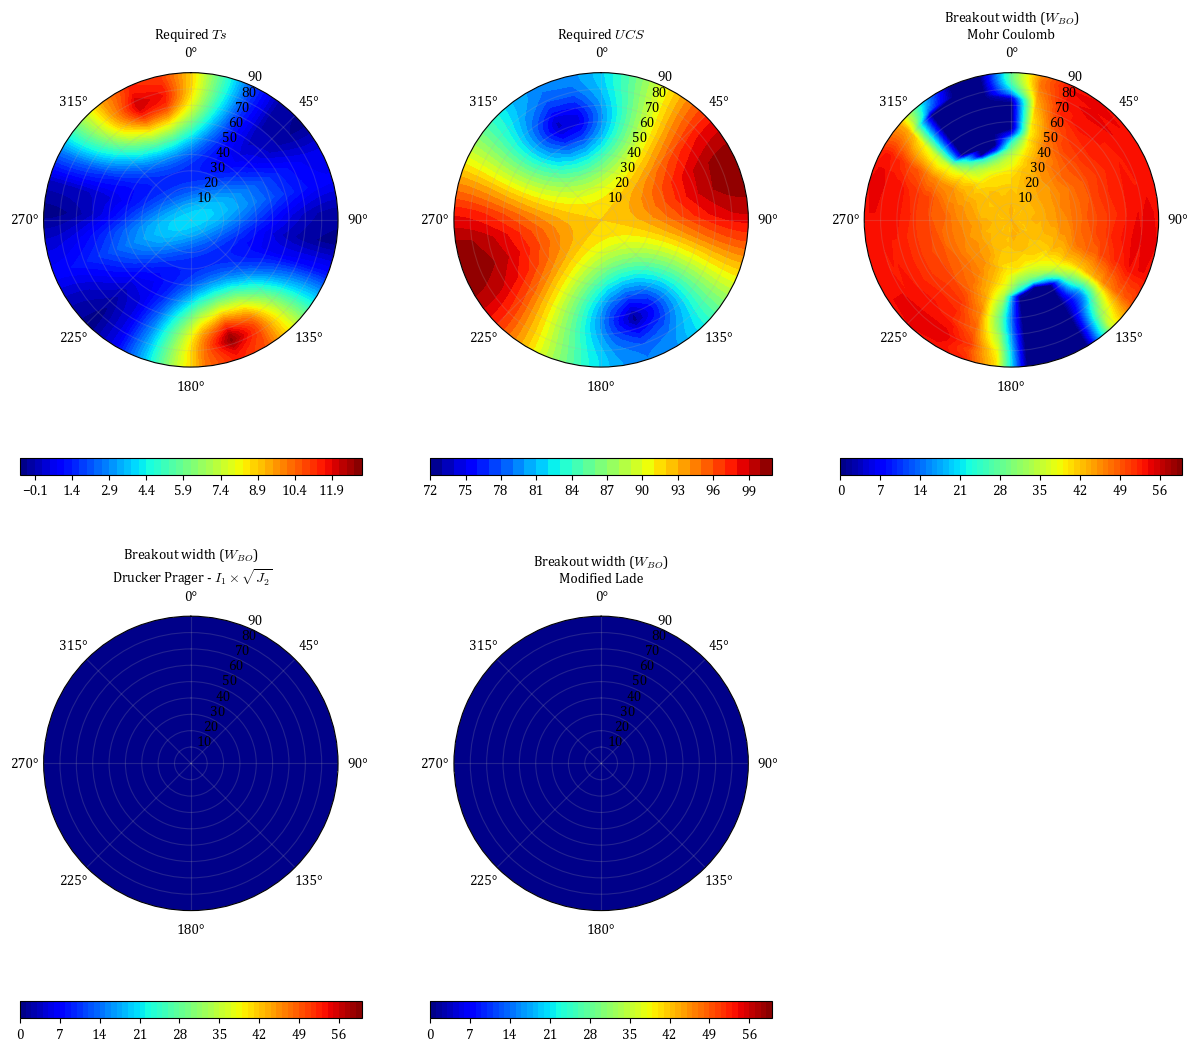

In [8]:
# Mohr coulomb failure criteria: Sig1 = UCS + Q * Sig3
MC_UCS=80.44
MC_Q=4.5881

# I1 x J2 Drucker Parger failure criteria: SQRT_J2 = C3 + V4 * I1
DP_C3=20.35
DP_C4=0.3174

# Parameters to the Modified Lade
S1 = 70 # Sv
S2 = 67 # Shmax
S3 = 45 # Shmin
AZIMUTH = 160
REGIME = 'NORMAL'

PP = 32
PW = 32
NU = 0.25

print ("ZOBACK - EXAMPLE 1 (NORMAL)")
build_polar_plots()

ZOBACK - EXAMPLE 2 (STRIKE SLIP)
Calculating ... 
Data build ... [ok]
Done


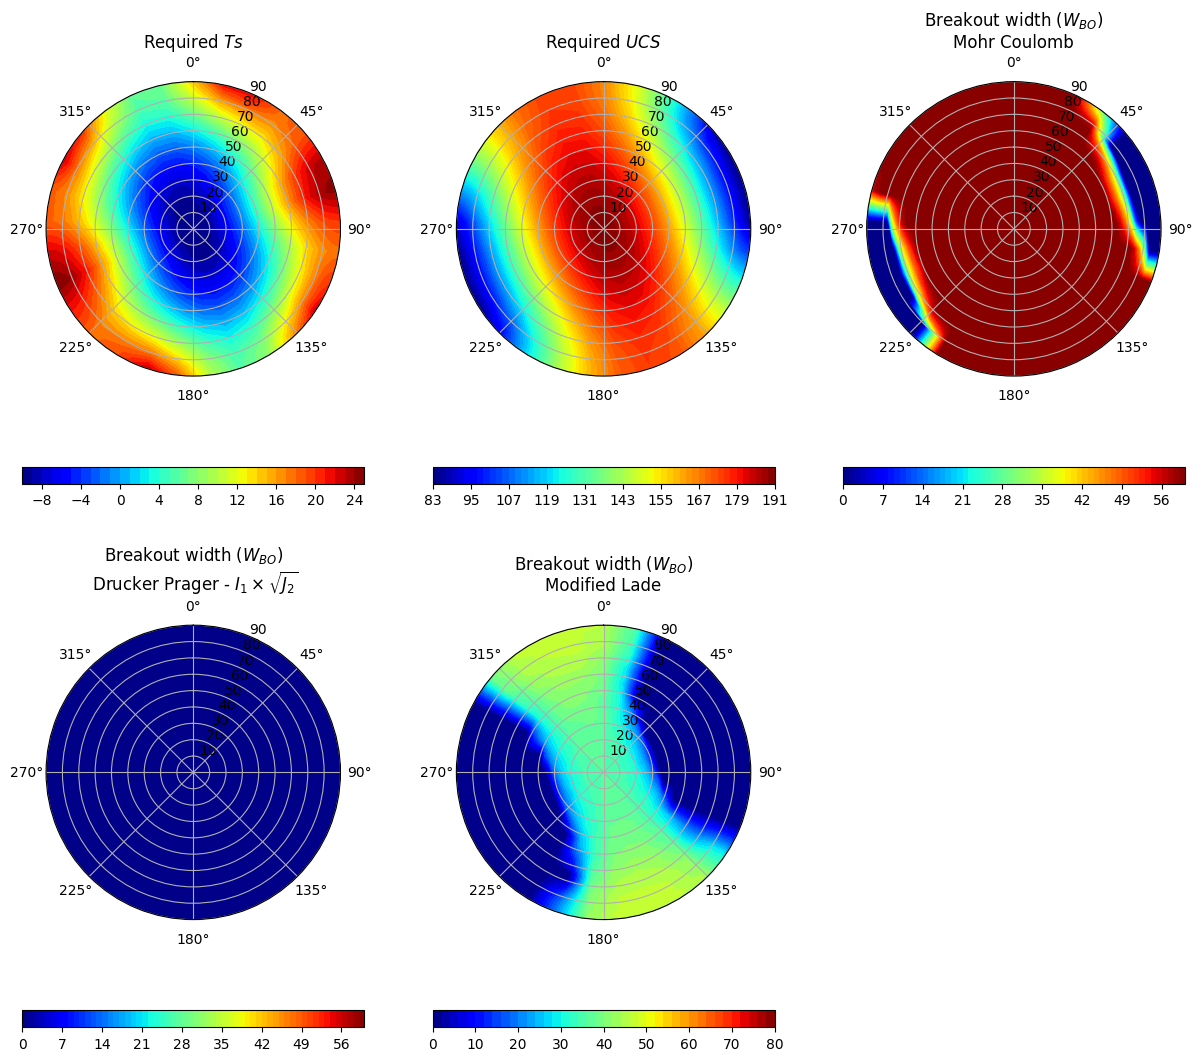

In [9]:
# Mohr coulomb failure criteria: Sig1 = UCS + Q * Sig3
MC_UCS=80.44
MC_Q=4.5881

# I1 x J2 Drucker Parger failure criteria: SQRT_J2 = C3 + V4 * I1
DP_C3=20.35
DP_C4=0.3174

# Parameters to the Modified Lade
S1 = 105   # Shmax
S2 = 70    # Sv
S3 = 55    # Shmin
AZIMUTH = 70
REGIME = 'STRIKESLIP'

PP = 32
PW = 38
NU = 0.25

print ("ZOBACK - EXAMPLE 2 (STRIKE SLIP)")
build_polar_plots()

ZOBACK - EXAMPLE 2 (REVERSE)
Calculating ... 
Data build ... [ok]
Done


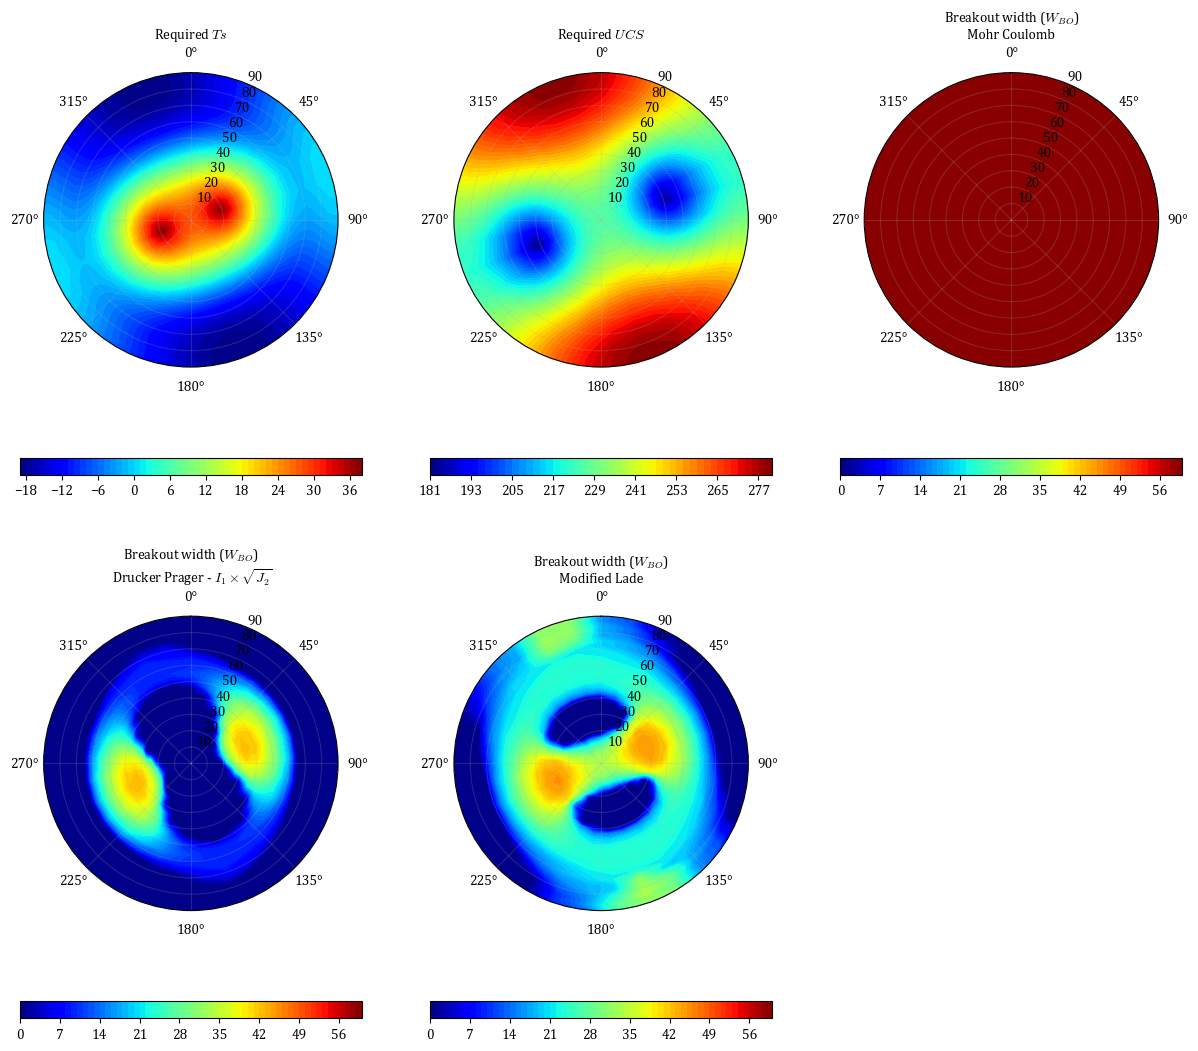

In [10]:
# Mohr coulomb failure criteria: Sig1 = UCS + Q * Sig3
MC_UCS=80.44
MC_Q=4.5881

# I1 x J2 Drucker Parger failure criteria: SQRT_J2 = C3 + V4 * I1
DP_C3=20.35
DP_C4=0.3174

# Parameters to the Modified Lade
S1 = 145   # Shmax
S2 = 125   # Shmin
S3 = 70    # Sv
AZIMUTH = 70
REGIME = 'REVERSE'

PP = 32
PW = 52
NU = 0.25

print ("ZOBACK - EXAMPLE 2 (REVERSE)")
build_polar_plots()

BREAKOUT ANALYSIS
Calculating ... 
Data build ... [ok]
Done


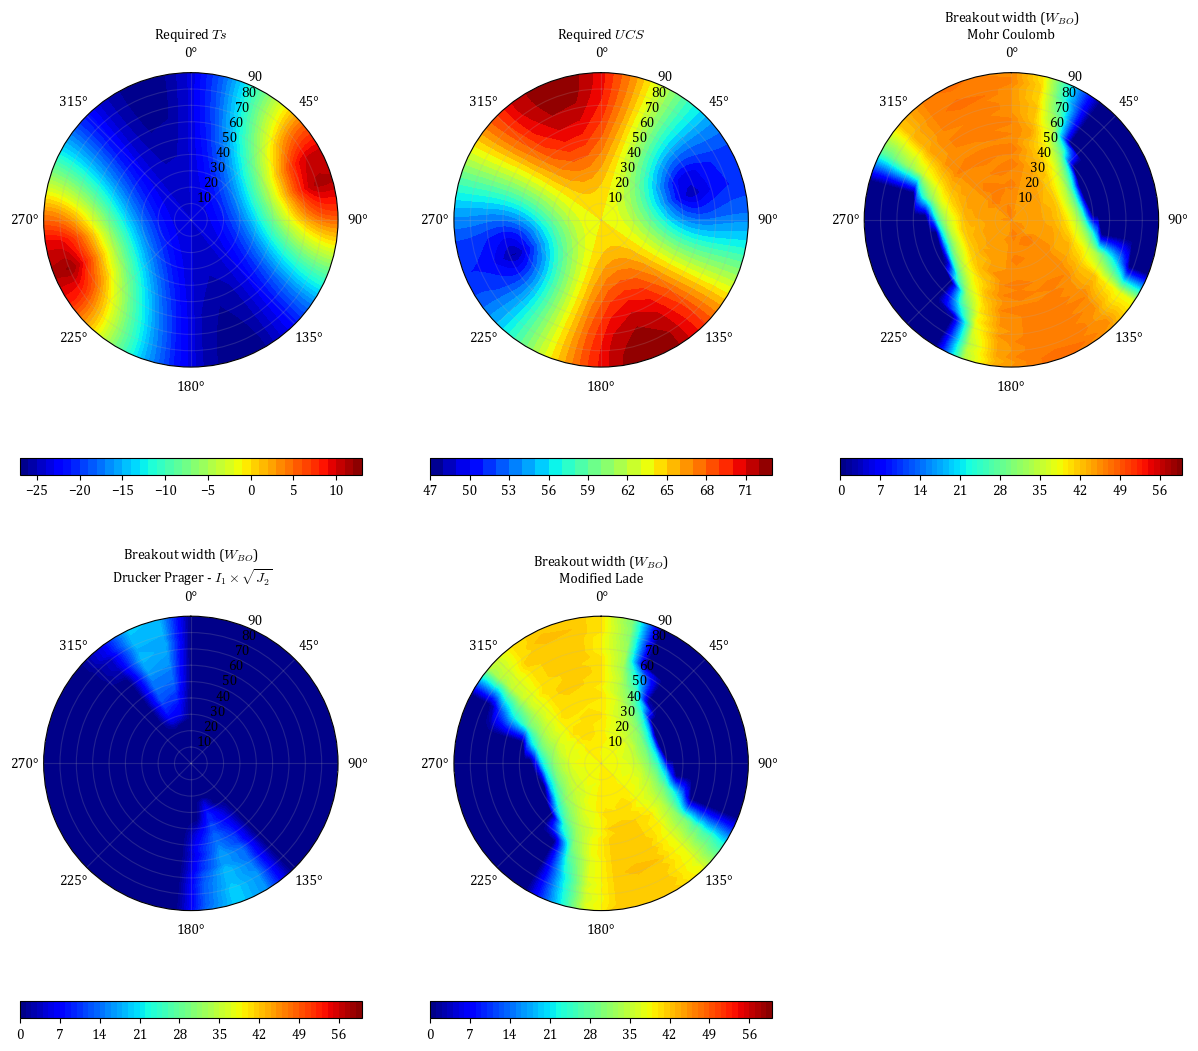

In [11]:
# Mohr coulomb failure criteria: Sig1 = UCS + Q * Sig3
MC_UCS=80.44
MC_Q=4.5881

# I1 x J2 Drucker Parger failure criteria: SQRT_J2 = C3 + V4 * I1
DP_C3=20.35
DP_C4=0.3174

# Parameters to the Modified Lade
S1 = 70   # Shmax
S2 = 67   # Shmin
S3 = 45    # Sv
AZIMUTH = 70
REGIME = 'NORMAL'

PP = 32
PW = 60
NU = 0.25

print ("BREAKOUT ANALYSIS")
build_polar_plots()